# Hit Advancment
Works for any baserunner checking to see if they advance an *extra* base after a hit (except batter obviously)

```python
df["threshold_rounded"] = 0.70 - 1.0*df["fielder_tenaciousness"] + 0.60*df['runner_continuation']
df["threshold_rounded"] = df["threshold_rounded"].clip(lower=0.01,upper=0.95)

```

In [357]:
# Load Dataframe

import glob

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("../roll_data/*-hitadvance.csv")

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# Select only advancement rolls from 2nd->3rd
# df = df[df['event_type']=='second']
# df = df[df['event_type']=='third']

seasons = [11,12,13,14]
df = df[df['season'].isin(seasons)]

# Remove Stadiums
# df = df[df['stadium_id'].isna()]

# Print initial and final states with this roll
print(df.groupby(['baserunners','baserunners_next']).size())


print(f"{len(df)} events.")

baserunners  baserunners_next
[0]          [1, 0]              2714
             [1]                  834
             [2, 0]              2645
             [2, 1]               757
[1, 0]       [1, 0]               354
             [1]                  164
             [2, 0]               668
             [2, 1, 0]            538
             [2, 1]               160
[1]          [0]                 1096
             [2, 0]              1003
[2, 0]       [1, 0]               371
             [1]                  100
             [2, 0]               357
             [2, 1]                95
[2, 1, 0]    [1, 0]               130
             [1]                   53
             [2, 0]               298
             [2, 1, 0]            195
             [2, 1]                49
[2, 1]       [0]                  155
             [2, 0]               156
dtype: int64
12892 events.


In [358]:
# Manual multiplier overrides
# Used this to figure out which mods do/don't apply
# -Remove growth for fielders
#
# df.loc[df["batting_team_mods"].astype(str).str.contains("OVERPERFORMING"), 'runner_multiplier'] -= 0.20
# df.loc[df["batting_team_mods"].astype(str).str.contains("HIGH_PRESSURE;OVERPERFORMING"), 'runner_multiplier'] -= 0.25 # Extra bit
# df.loc[df["batting_team_mods"].astype(str).str.contains("UNDERPERFORMING"), 'runner_multiplier'] += 0.20
# df.loc[df["runner_mods"].astype(str).str.contains("OVERPERFORMING"), 'runner_multiplier'] -= 0.20
# df.loc[df["runner_mods"].astype(str).str.contains("UNDERPERFORMING"), 'runner_multiplier'] += 0.20
# df.loc[(df["batting_team_mods"].astype(str).str.contains("AFFINITY_FOR_CROWS")) & df["weather"].str.contains("Weather.BIRDS"), 'runner_multiplier'] -= 0.50
# df.loc[(df["pitching_team_mods"].astype(str).str.contains("AFFINITY_FOR_CROWS")) & df["weather"].str.contains("Weather.BIRDS"), 'fielder_multiplier'] -= 0.50
# df["runner_multiplier"] = 1.
# df["fielder_multiplier"] = 1.

In [359]:
# Vibes
df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0
df.loc[df["runner_on_first_mods"].astype(str).str.contains("SCATTERED"), "runner_on_first_vibes"] = 0
df.loc[df["runner_on_second_mods"].astype(str).str.contains("SCATTERED"), "runner_on_second_vibes"] = 0
df.loc[df["runner_on_third_mods"].astype(str).str.contains("SCATTERED"), "runner_on_third_vibes"] = 0

df['batter_inv_patheticism'] = 1-df['batter_patheticism']/df["batter_multiplier"]
df['batter_inv_patheticism_with_vibe'] = df['batter_inv_patheticism'] * (1 + 0.2*df['batter_vibes'])
df['batter_inv_tragicness'] = 1-df['batter_tragicness']/df["batter_multiplier"]
df['batter_inv_tragicness_with_vibe'] = df['batter_inv_tragicness'] * (1 + 0.2*df['batter_vibes'])
df['vibes_mul'] = 1 + 0.2*df['batter_vibes']
for attr in [
    "batter_buoyancy",
    "batter_divinity",
    "batter_martyrdom",
    "batter_moxie",
    "batter_musclitude",
    "batter_patheticism",
    "batter_thwackability",
    "batter_tragicness",
    "batter_coldness",
    "batter_overpowerment",
    "batter_ruthlessness",
    "batter_shakespearianism",
    "batter_suppression",
    "batter_unthwackability",
    "batter_base_thirst",
    "batter_continuation",
    "batter_ground_friction",
    "batter_indulgence",
    "batter_laserlikeness",
    "batter_anticapitalism",
    "batter_chasiness",
    "batter_omniscience",
    "batter_tenaciousness",
    "batter_watchfulness",
    "batter_pressurization",
    "batter_cinnamon",
]:
    df[attr + "_scaled"] = df[attr] * df["batter_multiplier"]
    df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df["batter_vibes"])
df = df.copy()

for attr in [
    f"runner_base_thirst",
    f"runner_continuation",
    f"runner_ground_friction",
    f"runner_indulgence",
    f"runner_laserlikeness",
]:
    df[attr + "_scaled"] = df[attr] * df[f"runner_multiplier"]
    df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df[f"runner_vibes"])
for base in ["first","second","third","third_hh"]:
    for attr in [
        f"runner_on_{base}_base_thirst",
        f"runner_on_{base}_continuation",
        f"runner_on_{base}_ground_friction",
        f"runner_on_{base}_indulgence",
        f"runner_on_{base}_laserlikeness",
    ]:
        df[attr + "_scaled"] = df[attr] * df[f"runner_on_{base}_multiplier"]
        df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df[f"runner_on_{base}_vibes"])
df = df.copy()

for attr in [
    "pitcher_buoyancy",
    "pitcher_divinity",
    "pitcher_martyrdom",
    "pitcher_moxie",
    "pitcher_musclitude",
    "pitcher_patheticism",
    "pitcher_thwackability",
    "pitcher_tragicness",
    "pitcher_ruthlessness",
    "pitcher_overpowerment",
    "pitcher_unthwackability",
    "pitcher_shakespearianism",
    "pitcher_suppression",
    "pitcher_coldness",
    "pitcher_base_thirst",
    "pitcher_continuation",
    "pitcher_ground_friction",
    "pitcher_indulgence",
    "pitcher_laserlikeness",
    "pitcher_anticapitalism",
    "pitcher_chasiness",
    "pitcher_omniscience",
    "pitcher_tenaciousness",
    "pitcher_watchfulness",
    "pitcher_pressurization",
    "pitcher_cinnamon",
]:
    df[attr + "_scaled"] = df[attr] * df["pitcher_multiplier"]
    df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df["pitcher_vibes"])
df = df.copy()


for attr in [
    "fielder_anticapitalism",
    "fielder_chasiness",
    "fielder_omniscience",
    "fielder_tenaciousness",
    "fielder_watchfulness",
]:
    df[attr + "_scaled"] = df[attr] * df["fielder_multiplier"]
    df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df["fielder_vibes"])
df = df.copy()

len(df)

12892

In [360]:
# Ignore multipliers and some mods
# This has all been solved!

# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING", "SHELLED"]:
# for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "SHELLED"]:
#     df = df[~df["batter_mods"].astype(str).str.contains(exclude_mod)]
#     df = df[~df["pitcher_mods"].astype(str).str.contains(exclude_mod)]
#     df = df[~df["fielder_mods"].astype(str).str.contains(exclude_mod)]
#     df = df[~df["runner_mods"].astype(str).str.contains(exclude_mod)]
#     df = df[~df["runner_on_first_mods"].astype(str).str.contains(exclude_mod)]
#     df = df[~df["runner_on_second_mods"].astype(str).str.contains(exclude_mod)]
#     df = df[~df["runner_on_third_mods"].astype(str).str.contains(exclude_mod)]
#     df = df[~df["runner_on_third_hh_mods"].astype(str).str.contains(exclude_mod)]
#     df = df[~df["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
#     df = df[~df["batting_team_mods"].astype(str).str.contains(exclude_mod)]
print(len(df))
# Only use events with no multipliers
# df = df[
#     # (df["pitcher_multiplier"] == 1)
#     # & (df["batter_multiplier"] == 1)
#     # & (df["runner_multiplier"] == 1)
#     # & (df["fielder_multiplier"] == 1)
#     # & (df["runner_on_first_multiplier"] == 1)
#     # & (df["runner_on_second_multiplier"] == 1)
#     # & (df["runner_on_third_multiplier"] == 1)
#     # & (df["runner_on_third_hh_multiplier"] == 1)
# ]

print(len(df))

12892
12892


,roll,fielder_tenaciousness_scaled,runner_continuation_scaled
0,0.372624,1.016929,0.433531
1,0.215723,0.354689,0.984915
2,0.292207,0.360536,0.380000
3,0.737168,0.605566,0.853482
4,0.111461,0.657675,0.104629
...,...,...,...
12887,0.484431,0.243976,0.060984
12888,0.288287,0.180063,0.880971
12889,0.929824,0.732326,0.306203
12890,0.570548,0.294529,0.796654


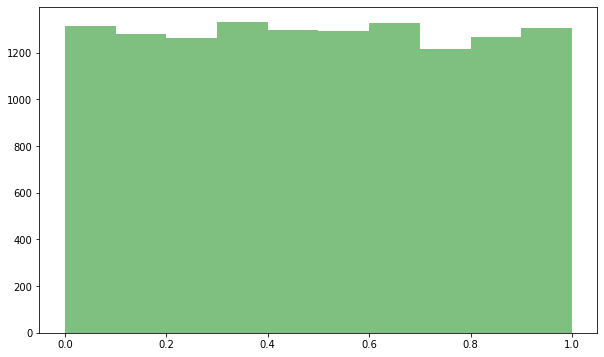

In [361]:
# Plot the roll
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    df['roll'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

X = df[
    [
        "roll",
        "passed",
        # "roll_avg",
        # "batter_buoyancy",
        # "batter_divinity_with_vibe",
        # "batter_martyrdom_with_vibe",
        # "batter_moxie_with_vibe",
        # "batter_musclitude_with_vibe",
        # "batter_patheticism_with_vibe",
        # "batter_thwackability_with_vibe",
        # "batter_tragicness_with_vibe",
        # "batter_musclitude_with_vibe",
        # "batter_patheticism_with_vibe",
        # "batter_inv_patheticism_with_vibe",
        # "batter_inv_patheticism",
        # "batter_tragicness_with_vibe",
        # "batter_inv_tragicness",
        # "pitcher_shakespearianism_with_vibe",
        # 'fielder_anticapitalism_with_vibe',
        # 'fielder_chasiness_with_vibe',
        # 'fielder_omniscience_with_vibe',
        # 'fielder_tenaciousness_with_vibe',
        'fielder_tenaciousness_scaled',
        # 'fielder_watchfulness_with_vibe',
        # 'pitcher_anticapitalism_with_vibe',
        # 'pitcher_chasiness_with_vibe',
        # 'pitcher_omniscience_with_vibe',
        # 'pitcher_tenaciousness_with_vibe',
        # 'pitcher_watchfulness_with_vibe',
        # 'runner_continuation_with_vibe',
        'runner_continuation_scaled',
        # 'runner_indulgence_with_vibe',
        # 'ballpark_grandiosity',
        # 'ballpark_fortification',
        # 'ballpark_obtuseness',
        # 'ballpark_ominousness',
        # 'ballpark_inconvenience',
        # 'ballpark_viscosity',
        # 'ballpark_forwardness',
        # 'ballpark_mysticism',
        # 'ballpark_elongation',
        # 'ballpark_filthiness',
    ]
]

# Test out a specific coefficient
# X["roll_advance"] = X["roll_advance"]+0.1*X["ballpark_elongation"]
# X.drop("ballpark_elongation", axis="columns", inplace=True)
# X["roll_advance"] = X["roll_advance"]+0.1*X["ballpark_inconvenience"]
# X.drop("ballpark_inconvenience", axis="columns", inplace=True)
y = X["passed"]
X = X.drop("passed", axis=1)
X

In [362]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

sc = StandardScaler()
X2 = sc.fit_transform(X)    

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(
    X2, y
)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[6153  127]
 [ 131 6481]]
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      6280
        True       0.98      0.98      0.98      6612

    accuracy                           0.98     12892
   macro avg       0.98      0.98      0.98     12892
weighted avg       0.98      0.98      0.98     12892

0.9799875892026063


In [363]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.68099256]


[(1.0, 'roll'),
 (0.9227140366041011, 'fielder_tenaciousness_scaled'),
 (-0.5551050258731083, 'runner_continuation_scaled')]

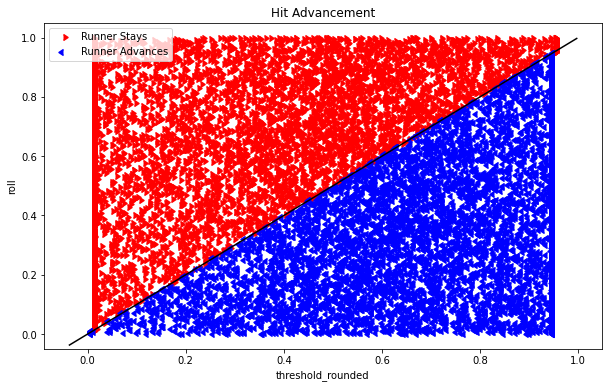

In [364]:
# Make scatter plot

# Manual threshold
df["threshold_rounded"] = 0.70 - 1.0*df["fielder_tenaciousness_scaled"] + 0.60*df['runner_continuation_scaled']
# df["threshold_rounded"] = 0.70 - 1.0*df["fielder_tenaciousness_with_vibe"] + 0.55*df['runner_continuation_with_vibe']
# df["threshold_rounded"] = df["threshold_rounded"].clip(lower=0.001)
df["threshold_rounded"] = df["threshold_rounded"].clip(lower=0.01,upper=0.95)
# print(df.loc[df["passed"], "roll"].max()) # How I found the upper bound

# SVC threshold
df["threshold"] = -intercept_scaled[0]
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll":
        df["threshold"] += pair[0] * df[pair[1]]

x_val = "threshold_rounded"
# x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.scatter(
    df[~df["passed"]][x_val],
    df[~df["passed"]]["roll"],
    color="red",
    label="Runner Stays",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    df[df["passed"]][x_val],
    df[df["passed"]]["roll"],
    color="blue",
    label="Runner Advances",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title("Hit Advancement")
# ax.set_xlim(0.484, 0.499)
ax.set_ylim(-0.05, 1.05)
ax.plot(ax.get_xlim(), ax.get_xlim(), "k")

ax.legend()


0 outliers


,passed,offset,roll,threshold_rounded,baserunners,baserunners_next,inning,runner_name,fielder_name,runner_mods,fielder_mods,batting_team_mods,pitching_team_mods,weather,season,day,game_id,play_count


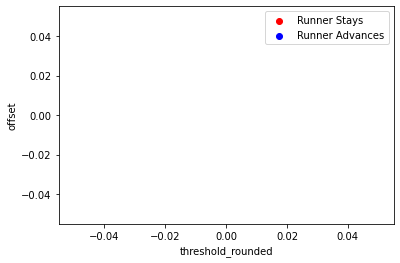

In [365]:
# Plot outliers
df["offset"] = df["roll"] - df["threshold_rounded"]
outliers = df[(df["passed"] & (df["offset"] >= 0)) | (~df["passed"] & (df["offset"] <= 0))]
print(f"{len(outliers)} outliers")

fig, ax = plt.subplots(1, facecolor='white')
x_val = "threshold_rounded"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Runner Stays",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Runner Advances",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

outliers[
    [
        "passed",
        "offset",
        "roll",
        "threshold_rounded",
        "baserunners",
        "baserunners_next",
        "inning",
        "runner_name",
        "fielder_name",
        "runner_mods",
        "fielder_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "weather",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
].sort_values("threshold_rounded")